In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/dogscats/"
sz = 256
bs = 5

In [4]:
torch.cuda.set_device(0)

In [5]:
torch.cuda.is_available()

True

In [6]:
arch = resnext101_64
tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on)
data = ImageClassifierData.from_paths(PATH, bs = bs, tfms = tfms, num_workers = 12)
learn = ConvLearner.pretrained(arch, data, precompute = True)

In [7]:
lrf = learn.lr_find()

 52%|█████████████████████████████████▉                               | 2399/4600 [00:11<00:10, 202.64it/s, loss=0.468]

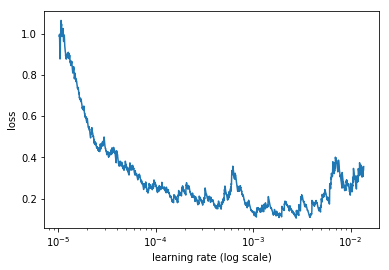

In [9]:
learn.sched.plot()

In [10]:
learn.fit(1e-3, 2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.151419   0.02881    0.994     
    1      0.08495    0.02047    0.995                                                                                 


[array([0.02047]), 0.9950000002980233]

In [11]:
learn.fit(1e-3, 3, cycle_len = 1)
learn.precompute = False

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.075693   0.037083   0.991     
    1      0.105602   0.02131    0.9945                                                                                
    2      0.105453   0.022459   0.994                                                                                 


In [12]:
learn.unfreeze()
lr = np.array([1e-5, 1e-4, 1e-3])

In [13]:
lrf = learn.lr_find()

 41%|██████████████████████████▉                                       | 1876/4600 [14:35<21:11,  2.14it/s, loss=0.516]

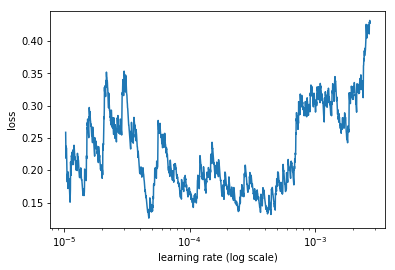

In [16]:
learn.sched.plot()
#??? Unsure of what happened. Overfitted?
#SZ of 128 and BS of 32 tried later with more suitable graphs but less accuracy. ~98.8%

In [17]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.20516    0.035995   0.9885    
    1      0.134297   0.020075   0.994                                                                                 
    2      0.120258   0.028705   0.9915                                                                                
    3      0.092674   0.021412   0.9935                                                                                
    4      0.124607   0.019629   0.994                                                                                 
    5      0.113563   0.020429   0.9925                                                                                
    6      0.111883   0.017227   0.9935                                                                                


[array([0.01723]), 0.9935000003874301]

In [31]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[979  21]
 [ 16 984]]


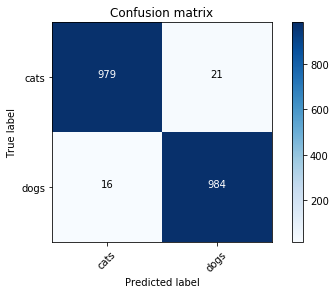

In [32]:
plot_confusion_matrix(cm, data.classes)

In [33]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


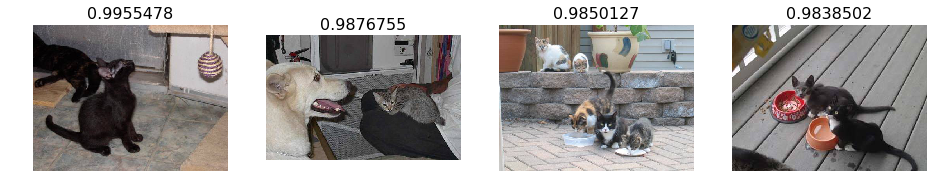

In [36]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


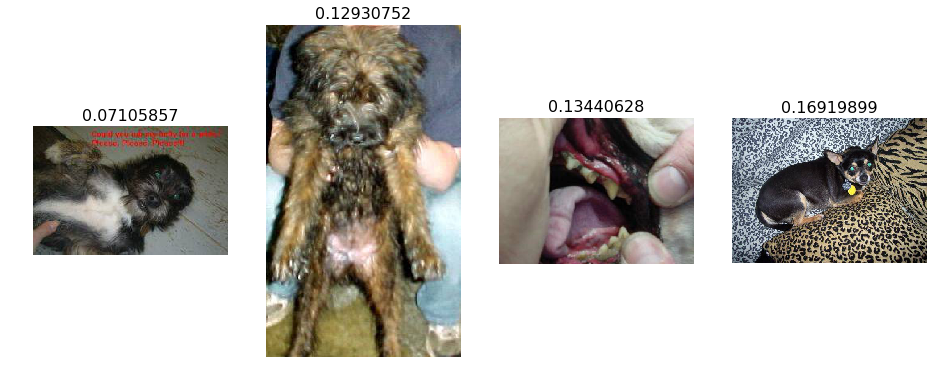

In [37]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")